For the top 3 genres, what is the average domestic and foreign YoY gross revenue? What is the relationship between production cost and gross revenue?

In [1]:
from module1_util_scripts.sqlreader import SQLReader
from module1_util_scripts.grapher import Grapher
from module1_util_scripts.cleaner import DatasetCleaner
from module1_util_scripts.loader import Loader
import pandas as pd

In [2]:
def generate_df():
    
    #query the table created and uploaded in question join, and joine with the tn_movie_budgets dataset
    #on matching movie titles
    #the numeric columns in the tn_movie_budgets table are actually strings with commas and dollar signs
    #these were removed in the query, and then using pandas, the datatype was converted to float
    #calc total revenue and total revenue - production cost spread
    datasets = 'zippedData/'
    configs = 'configs/'
    global threshold_config
    threshold_config = Loader(datasets_folderpath=datasets, configs_folderpath=configs).read_configs()['thresholds']
    query = """
            SELECT r.original_title, r.start_year, r.genres,
                    REPLACE(REPLACE(b.production_budget, '$', ''), ',', '') production_budget, 
                    REPLACE(REPLACE(b.domestic_gross, '$', ''), ',', '') domestic_gross, 
                    REPLACE(REPLACE(b.worldwide_gross, '$', ''), ',', '') worldwide_gross
            FROM derived_ratings_df r
            LEFT JOIN tn_movie_budgets b
            ON b.movie = r.original_title
            WHERE (b.domestic_gross IS NOT NULL 
                    AND b.worldwide_gross IS NOT NULL 
                    AND b.production_budget IS NOT NULL)
                    AND r.genres IN ('Biography', 'Animation', 'Sci-Fi');
            """
    db = 'movies_db.sqlite'
    df = SQLReader.read(query, db)
    df = df.applymap(lambda x: float(x) if isinstance(x, str) and x.isdigit() else x)
    df['revenue'] = df['domestic_gross'] + df['worldwide_gross']
    df['spread'] = df['revenue'] - df['production_budget']
    return df
    

In [3]:
def plot_yoy_rev(df):
    
    #plot year over year gross domestic and worldwide revenue 
    label_dict = {'YoY Gross Domestic Revenue': 'domestic_gross', 'YoY Gross Worldwide Revenue': 'worldwide_gross'}
    for label, col in label_dict.items():
        
        plot_df = df.groupby(['start_year', 'genres'])[[col]].mean().unstack()
        plot_df.columns = plot_df.columns.droplevel(0)
        plot_df = plot_df[plot_df.index.isin([i for i in range(2010,2020)])].copy()
        Grapher.plot_multiple_line_graph('Year', 'Gross Revenue', label, plot_df)

In [4]:
def plot_yoy_spread(df):
    
    #plot year over year spread
    plot_df = df.groupby(['start_year', 'genres'])[['spread']].mean().unstack()
    plot_df.columns = plot_df.columns.droplevel(0)
    plot_df = plot_df[plot_df.index.isin([i for i in range(2010,2020)])].copy()
    Grapher.plot_multiple_line_graph('Year', 'Spread', 'YoY Revenue/Budget Spread', plot_df)

In [5]:
def plot_regressions(df):
    
    #plot scatterplot of production budget and gross spread
    #perform linear regression and display linear equation
    for genre in df['genres'].unique():
        
        title = f'{genre} Production Budget vs Gross Spread Linear Regression'
        plot_df = df.loc[df['genres'] == genre].copy()
        plot_df = plot_df[['production_budget', 'spread']]
        plot_df.index = plot_df['production_budget']
        plot_df = plot_df[['spread']]
        plot_df =  DatasetCleaner.clean(plot_df, threshold_config).dropna()
        Grapher.plot_scatter('Production Budget', 'Spread', title, plot_df)

In [6]:
df = generate_df()

Reading thresholds.json with Loader
Processing SQL Query with SQLReader
Connecting to movies_db.sqlite with SQLReader
Sucessfully fetched query results with SQLReader
Closed connection to movies_db.sqlite with SQLReader


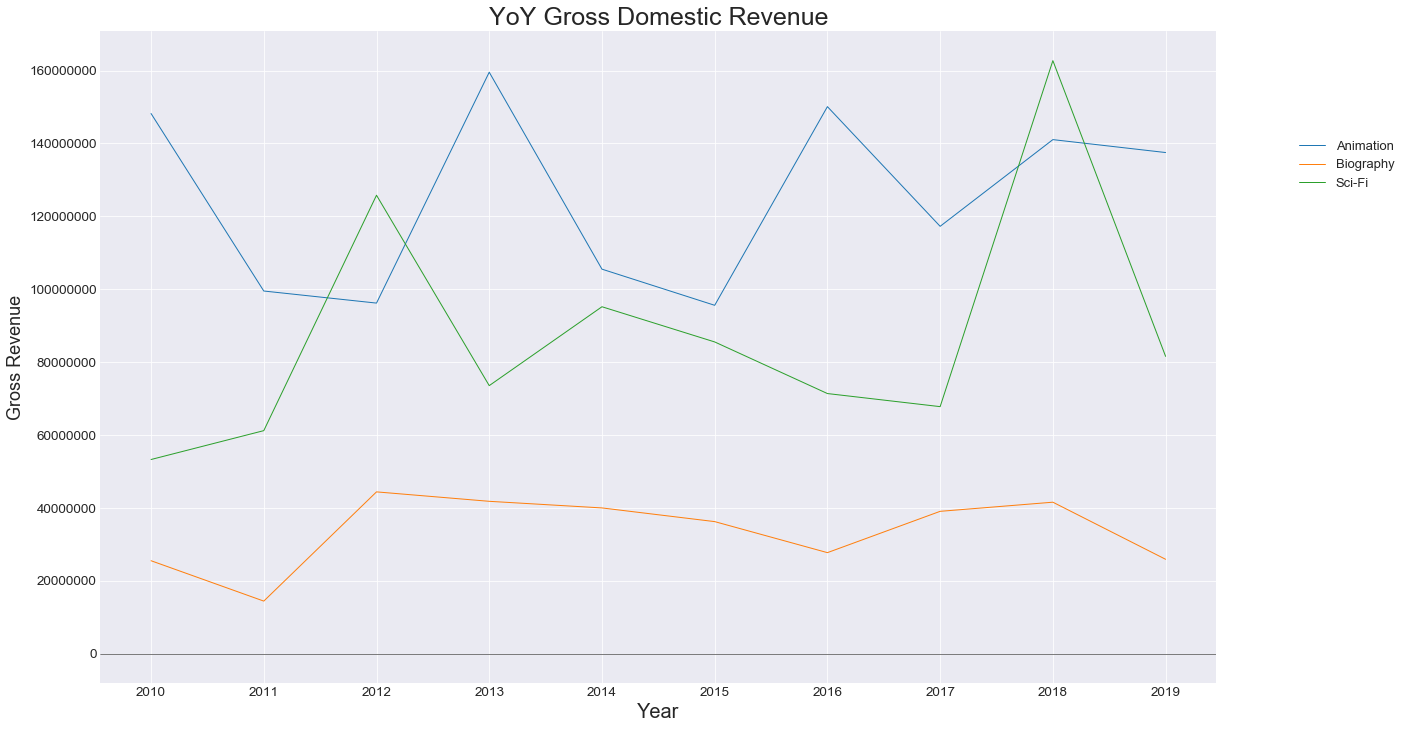

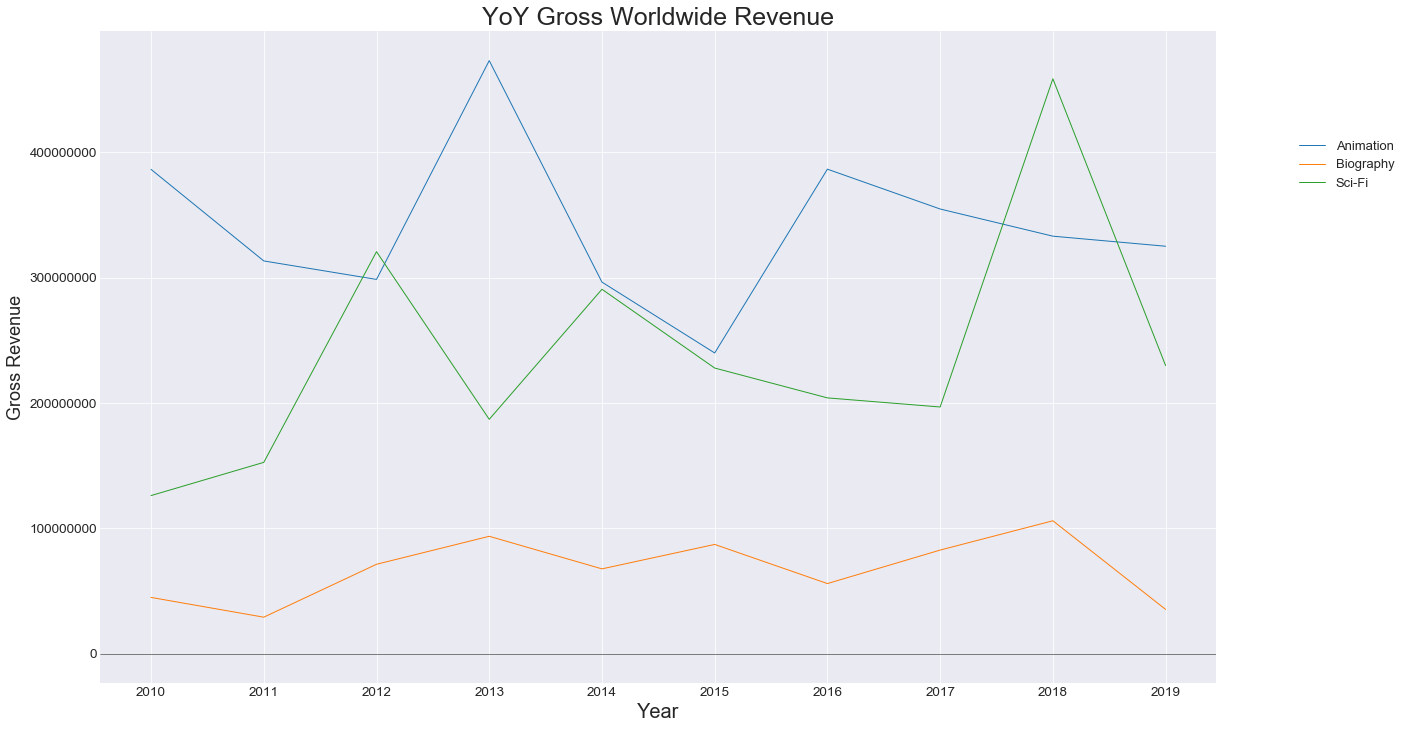

In [7]:
plot_yoy_rev(df)

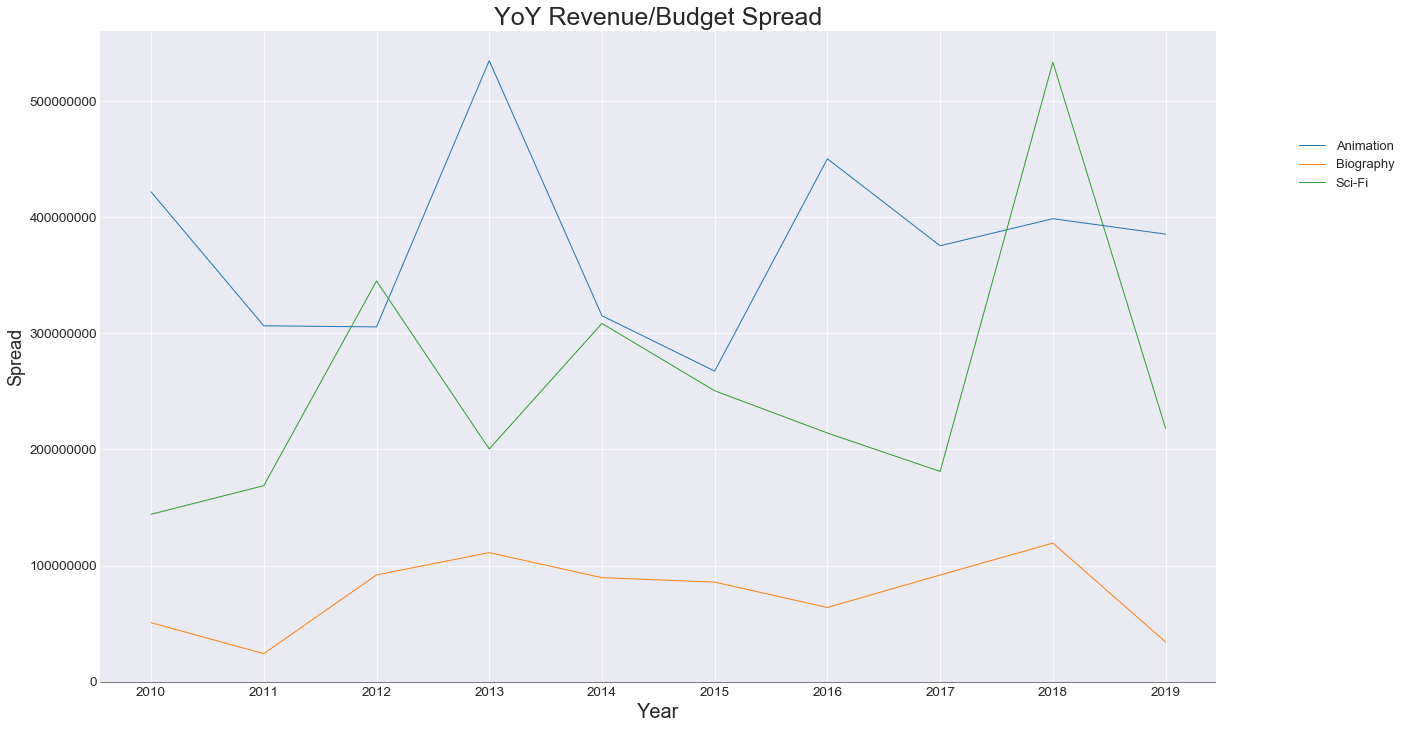

In [8]:
plot_yoy_spread(df)

No handles with labels found to put in legend.


Cleaning dataset with DatasetCleaner
Finished cleaning dataset with DatasetCleaner


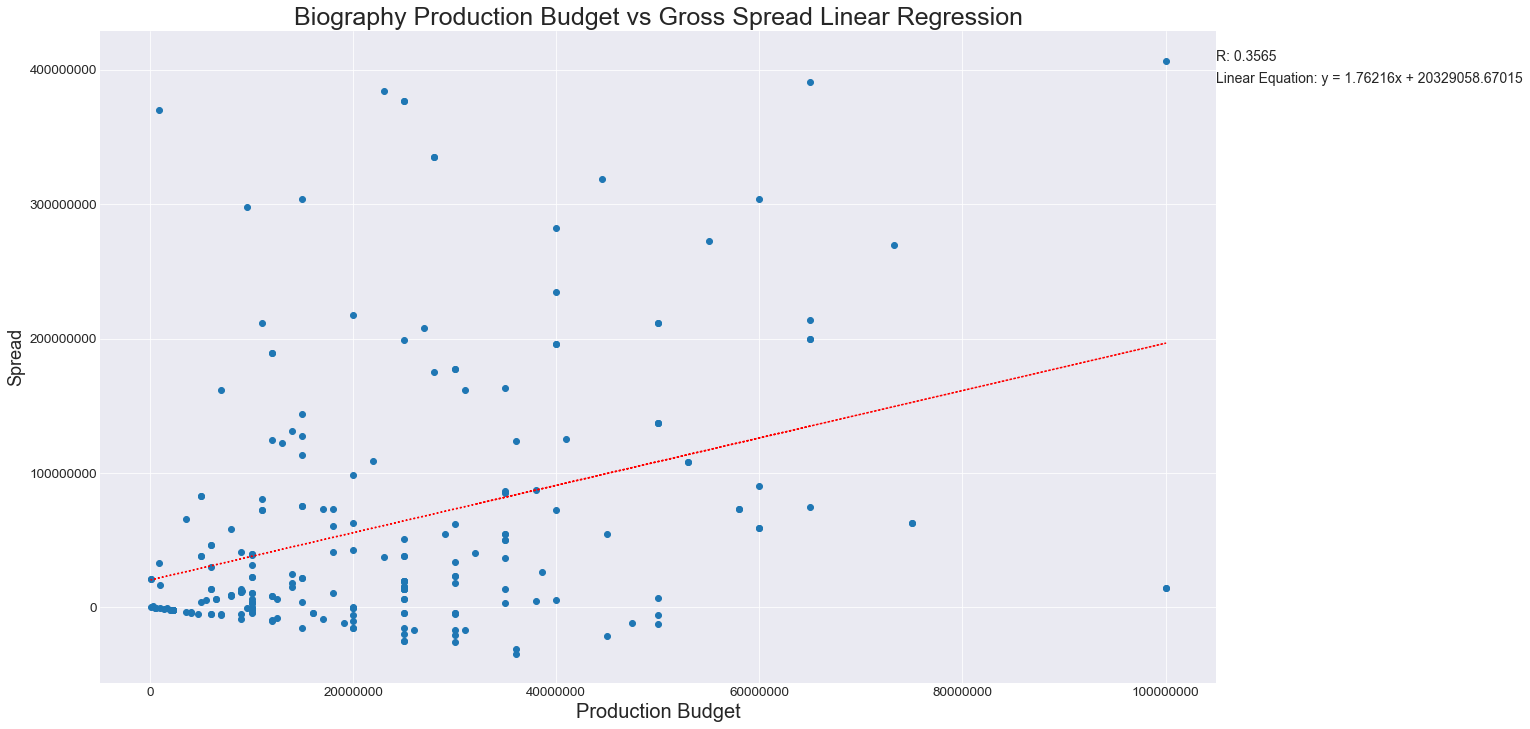

No handles with labels found to put in legend.


Cleaning dataset with DatasetCleaner
Finished cleaning dataset with DatasetCleaner


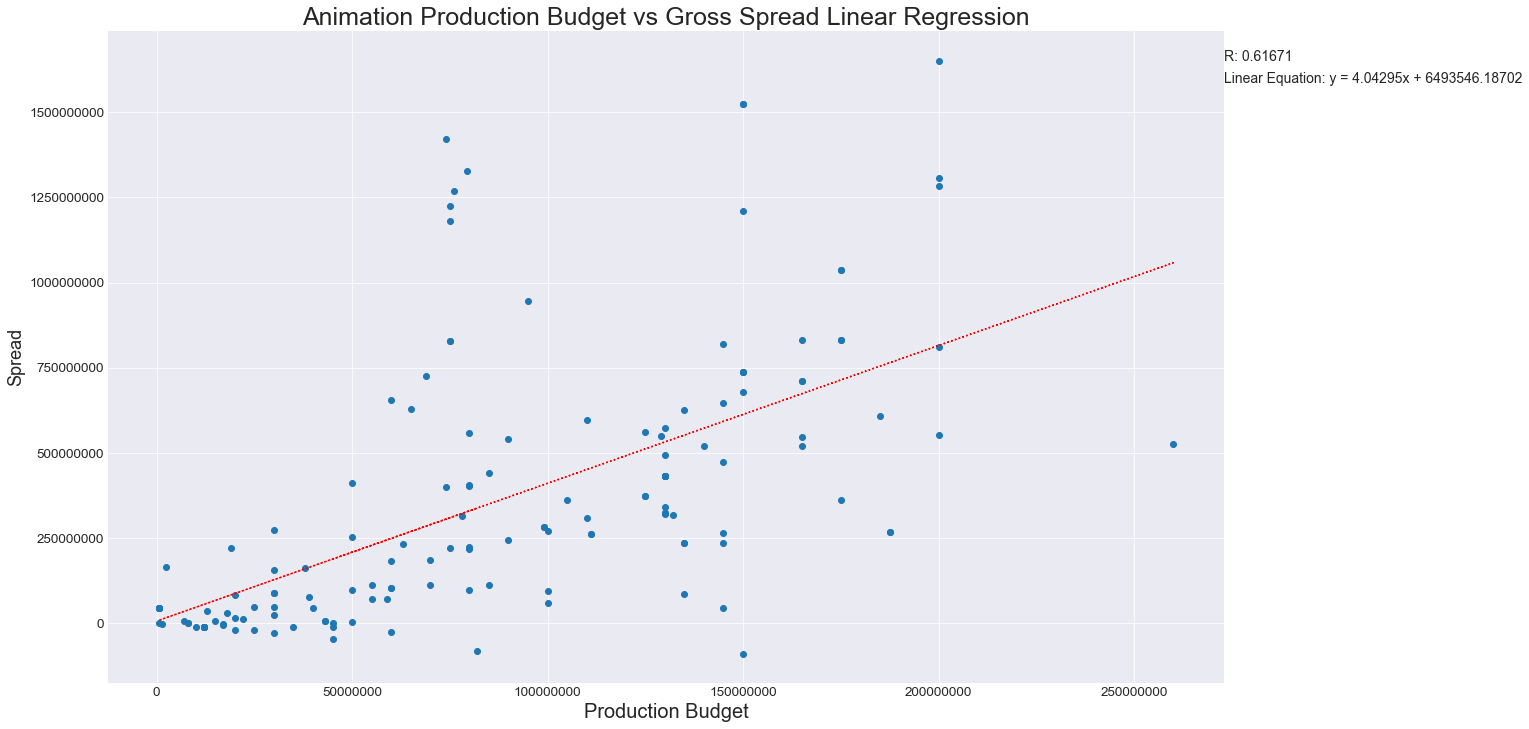

No handles with labels found to put in legend.


Cleaning dataset with DatasetCleaner
Finished cleaning dataset with DatasetCleaner


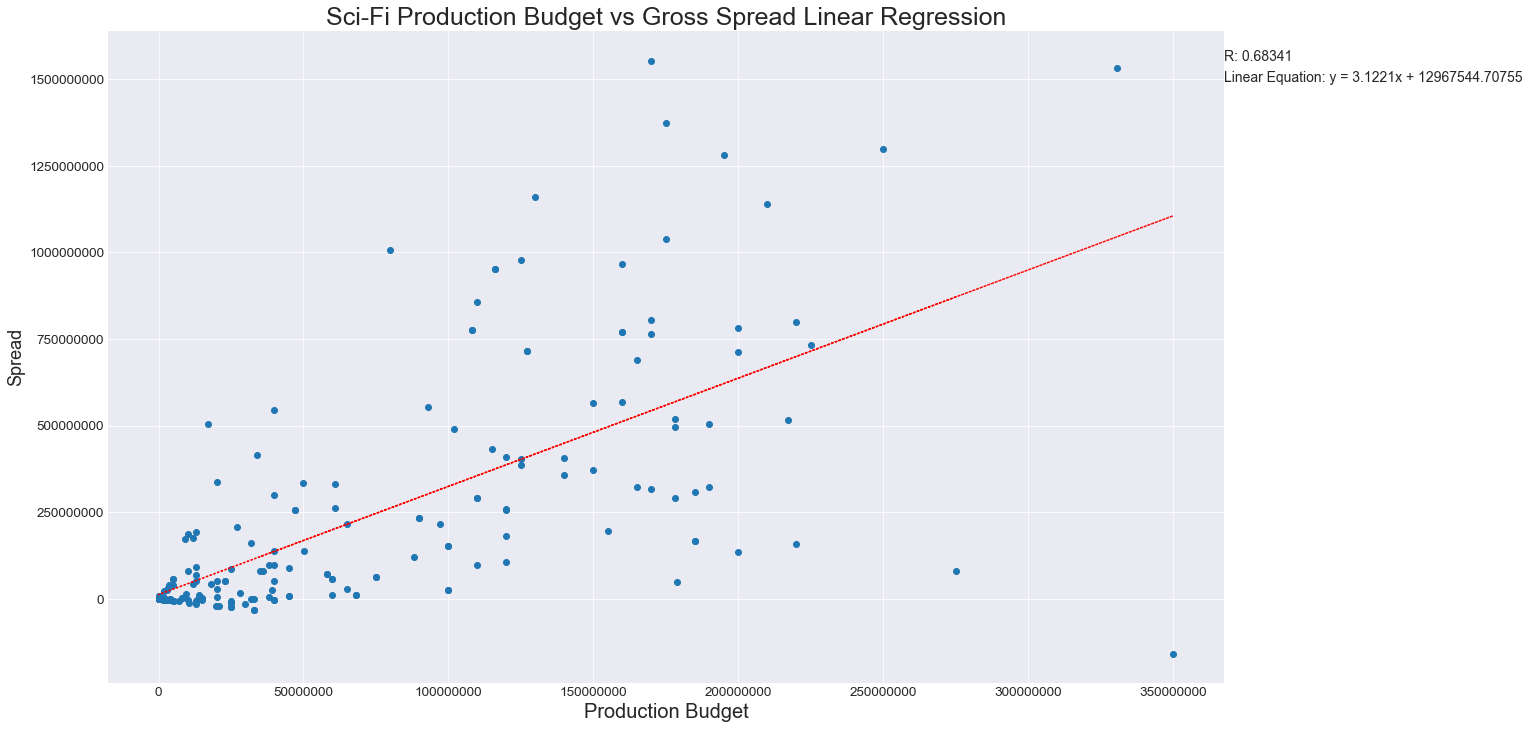

In [9]:
plot_regressions(df)